In [1]:
import casadi as ca

# Define the states
x1 = ca.MX.sym('x1')
x2 = ca.MX.sym('x2')
x  = ca.vertcat(x1, x2)

# Define the controls
u  = ca.MX.sym('u')

# Van der Pol oscillator system (nonlinear ODE)
ode = ca.vertcat(x2, (1 - x1**2)*x2 - x1 + u)

# Create the function
f = ca.Function('f', [x, u], [ode], ['x', 'u'], ['ode'])

# Evaluate the function
print(f(ca.vertcat(0.2, 0.8), 0.1))

[0.8, 0.668]


In [2]:
# Constants
T = 10  # Time horizon
N = 100  # Number of control intervals

# DAE problem structure

dae = {'x':x, 'p':u, 'ode':ode}

# Integrator options
intg_options = {
    'tf': T/N,
    'simplify': True,
    'number_of_finite_elements': 4
}

# Create the integrator
intg = ca.integrator('intg', 'rk', dae, intg_options)

CasADi - 2023-09-24 13:21:57 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [3]:
res = intg(x0=ca.vertcat(0,1), p=0)
print(res['xf'])

[0.104986, 1.09943]


In [4]:
res = intg(x0=x, p=u)

# Extract the final state
x_next = res["xf"]

In [5]:
# Simplify API to (x,u)->(x_next)
F = ca.Function('F', [x, u], [x_next], ['x', 'u'], ['x_next'])

# Evaluating the function with given inputs
print(F(ca.vertcat(0, 1), 0))
print(F(ca.vertcat(0.1, 0.9), 0.1))

[0.104986, 1.09943]
[0.194411, 0.987648]


In [6]:
sim = F.mapaccum(N)

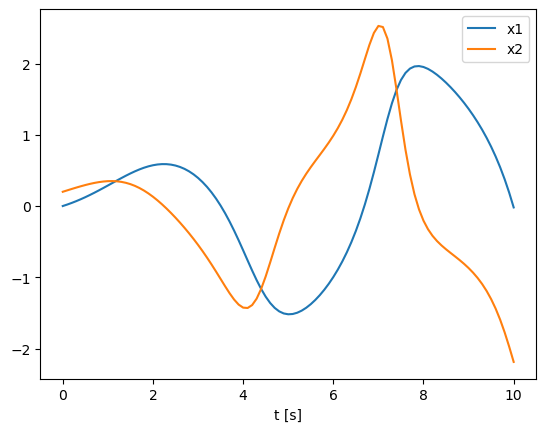

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the initial condition and evaluate the simulation
x0 = ca.vertcat(0, 0.2)
res = sim(x0, np.zeros((1, N)))

# Extract states from result
x1_res = res[0, :].full().flatten()
x2_res = res[1, :].full().flatten()

# Concatenate initial condition
x1_full = np.concatenate(([float(x0[0])], x1_res))
x2_full = np.concatenate(([float(x0[1])], x2_res))

# Plotting
tgrid = np.linspace(0, T, N+1)
plt.figure()
plt.plot(tgrid, x1_full, label='x1')
plt.plot(tgrid, x2_full, label='x2')
plt.legend()
plt.xlabel('t [s]')
plt.show()


100 100


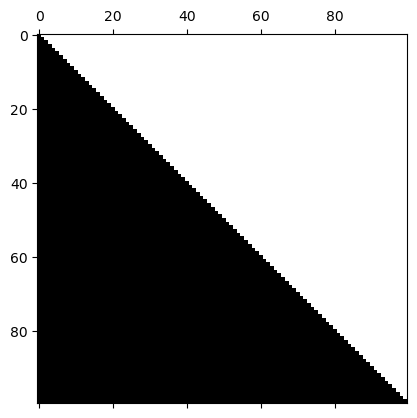

In [8]:
# Assuming sim, N, and x0 are defined as in previous snippets...

# Define symbolic input series
U = ca.MX.sym('U', 1, N)

# Simulate using concrete x0 and symbolic input series
X1 = sim(x0, U)[0, :]

# Jacobian of first states with respect to the input series
J = ca.jacobian(X1, U)

# Print the size of J
print(J.size1(), J.size2())

# Visualize the sparsity pattern
plt.spy(J.sparsity())
plt.show()

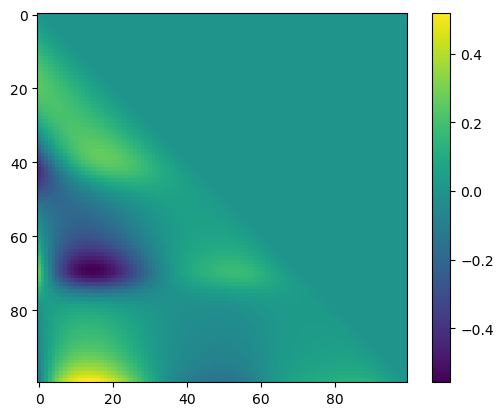

In [9]:
# Define function Jf
Jf = ca.Function('F', [U], [J])

# Evaluate the function with a zero input and convert to a full matrix
Jf_evaluated = Jf(0).full()

# Display the matrix as an image
plt.imshow(Jf_evaluated)
plt.colorbar()  # Optional: Adds a colorbar to the side
plt.show()

In [10]:

opti = ca.Opti()
x = opti.variable(2, N+1)  # Decision variables for state trajectory
u = opti.variable(1, N)
p = opti.parameter(2, 1)  # Parameter (not optimized over)

objective = ca.sum1(ca.sum2(x**2)) + ca.sum1(ca.sum2(u**2))
opti.minimize(objective)

for k in range(N):
    opti.subject_to(x[:, k+1] == F(x[:, k], u[:, k])) #dynamics difference equation

# Constraints
for i in range(N):
    opti.subject_to(u[:, i] >= -1) #input constraints lower
    opti.subject_to(u[:, i] <= 1) #input constraints upper

opti.subject_to(x[:, 0] == p)


In [11]:

# Choose IPOPT as a solver
solver_opts = {'ipopt': {'print_level': 12, 'tol': 1e-6}}  # for example, to increase print level and set tolerance
opti.solver('ipopt', solver_opts)

# Set a concrete value for p
opti.set_value(p, [0, 0.2])

# Solve the optimization problem
sol = opti.solve()


List of options:

                                    Name   Value                # times used
                           linear_solver = mumps                     2
                             print_level = 12                        2
                                     tol = 1e-06                     2

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:      602

Scaling parameter for objective functio

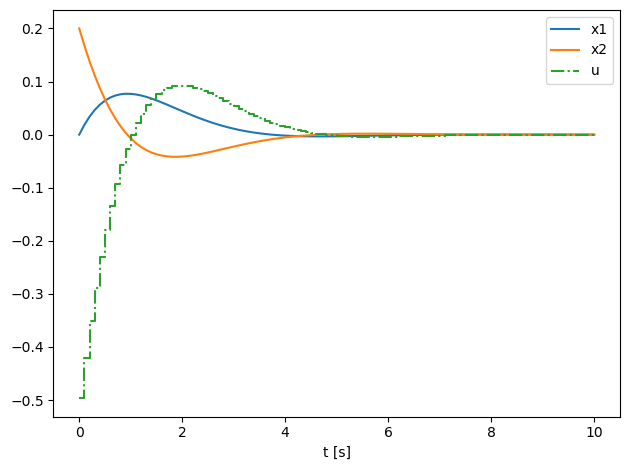

In [12]:
plt.figure()

# Plot state trajectories
plt.plot(tgrid, sol.value(x).T)  # Transpose might be needed depending on shape

# Plot control trajectory
# Adding nan to ensure the same length for stairs plot
u_values = np.append(sol.value(u), np.nan)
plt.step(tgrid, u_values, where='post', linestyle='-.')  # 'stairs' in MATLAB corresponds to 'step' in matplotlib

# Label axes and legend
plt.xlabel('t [s]')
plt.legend(['x1', 'x2', 'u'])

# Display the figure
plt.tight_layout()  # This can help in making the figure "nice", similar to the `nice_fig` function
plt.show()